In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
import datetime

import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt

from ml.opt_weights import *
from ml.model_inputs import *
from ml.constructions import *
from ml.tests.gen_data import *
from ml.model import *
import ml.utils as ut

notes:
- use this: 
https://tensorflow.googlesource.com/tensorflow/+/master/tensorflow/models/image/mnist/convolutional.py
- output model weights
- make sure dropout it isn't applied to non train predictions
- get tensorboard working correctly
- add tensorboard saver to reinstantiate model
https://www.tensorflow.org/versions/r0.7/tutorials/mnist/tf/index.html#evaluate-the-model

In [57]:
ret = (pd.read_csv('data/returns.csv', parse_dates=['DATE'], index_col=0)
       .dropna(how='all')
       .replace(np.nan,0))
ret = ret[[c for c in ret.columns if 'anti' not in c]]

In [59]:
ret.loc['2008-01-14'] = np.nan
ret = ret.dropna(how='all')

In [60]:
def add_cash(df):
    cash = np.random.randn(df.shape[0]) * 1e-10
    cash =  pd.Series(cash, name='cash', index=df.index)
    return pd.concat([df, cash], axis=1)
    
ret = add_cash(ret)

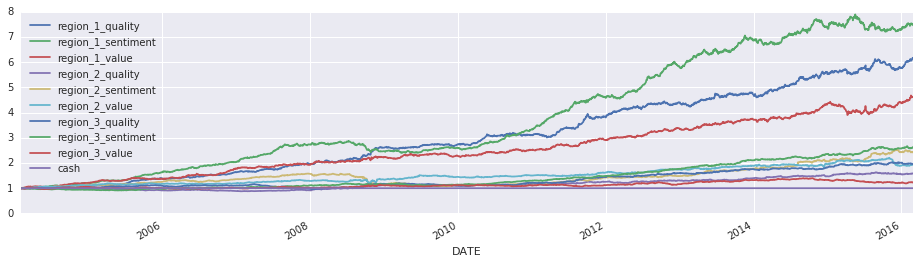

In [61]:
ret.applymap(lambda x: x + 1.).cumprod().plot(figsize=[16,4])

find optimal target regression parameters

In [62]:
# tilt_weights = calc_opt_weights(ret, alpha=9, norm_type=2, long_only=True)
# # tilt_weights = ut.get_mean_var_tilt_holdings(ret, halflife=36*22)
# tilt_weights.plot(kind='bar', ylim=[0,.25], figsize=[8,3])

In [63]:
# grid = opt_weight_ir_grid(ret, 
#                           np.exp(np.linspace(-4, 2, 8)), 
#                           look_ahead_pers=range(5,100,20), 
#                           tilt_weights=tilt_weights)
# grid.to_csv('data/opt_weight_ir_grid.csv', index=None)

In [64]:
# equal_weights = pd.Series({k: 1./ret.shape[1] for k in ret.columns})
# equal_weight_ir = ut.get_ir(ret.mul(equal_weights).sum(axis=1))
# print('equal weight ir:\t{0}'.format(equal_weight_ir))
# tilt_weight_ir = ut.get_ir(ret.mul(tilt_weights).sum(axis=1))
# print('tilt weight ir:\t\t{0}'.format(tilt_weight_ir))

# grid = pd.read_csv('data/opt_weight_ir_grid.csv')
# grid[grid.norm_type==2].pivot(index='alpha', columns='look_ahead_per', values='ir')

prep model inputs

In [65]:
alpha = .4
look_ahead_per = 30
opt_weights_func = lambda x: calc_opt_weights(x, alpha=alpha, norm_type=2)
opt_weights = rolling_fit_opt_weights(ret, opt_weights_func, look_ahead_per)
# opt_weights -= tilt_weights

In [66]:
#tilt_weights = opt_weights.mean(axis=0)
tilt_weights = opt_weights.median(axis=0)
opt_weights -= tilt_weights

turnover:	34.4586455072
ir:		5.86765030657


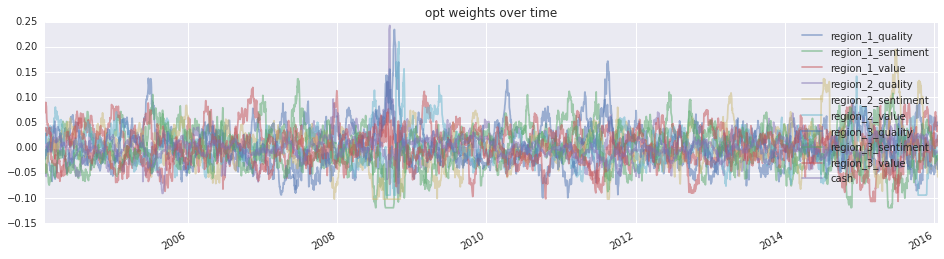

In [67]:
opt_weights.plot(alpha=.5, figsize=[16,4], title='opt weights over time')
print('turnover:\t{0}'.format(ut.calc_annual_turnover(opt_weights)))
print('ir:\t\t{0}'.format(ut.get_ir(ret.mul(opt_weights).sum(axis=1))))

region_1_quality      0.5
region_1_sentiment    0.5
region_1_value        0.5
region_2_quality      0.5
region_2_sentiment    0.5
region_2_value        0.5
region_3_quality      0.5
region_3_sentiment    0.5
region_3_value        0.5
cash                  0.5
dtype: float64

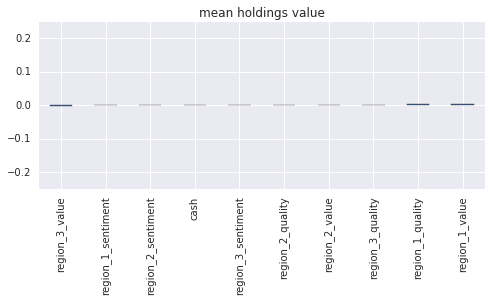

In [68]:
opt_weights.mean(axis=0).sort_values().plot(figsize=[8,3], ylim=[-.25,.25], kind='bar', title='mean holdings value')
ut.calc_ratio_above_zero(opt_weights).sort_values()

,region_1_quality,region_1_sentiment,region_1_value,region_2_quality,region_2_sentiment,region_2_value,region_3_quality,region_3_sentiment,region_3_value,cash
region_1_quality,1.000000,-0.220533,0.263422,-0.134598,-0.274921,-0.243816,-0.111694,-0.276378,-0.079169,-0.296383
region_1_sentiment,-0.220533,1.000000,-0.064390,-0.290017,0.036231,-0.082968,-0.319890,-0.020973,-0.208180,-0.129782
region_1_value,0.263422,-0.064390,1.000000,-0.269074,-0.289080,-0.169106,-0.176121,-0.289829,-0.162451,-0.149673
region_2_quality,-0.134598,-0.290017,-0.269074,1.000000,-0.108623,-0.014881,0.079379,-0.066684,0.064802,0.069227
region_2_sentiment,-0.274921,0.036231,-0.289080,-0.108623,1.000000,-0.228643,-0.156622,0.142465,-0.209093,-0.005632
region_2_value,-0.243816,-0.082968,-0.169106,-0.014881,-0.228643,1.000000,0.000947,-0.129588,-0.021564,0.137561
region_3_quality,-0.111694,-0.319890,-0.176121,0.079379,-0.156622,0.000947,1.000000,-0.101928,0.005740,-0.050342
region_3_sentiment,-0.276378,-0.020973,-0.289829,-0.066684,0.142465,-0.129588,-0.101928,1.000000,-0.170367,0.136590
region_3_value,-0.079169,-0.208180,-0.162451,0.064802,-0.209093,-0.021564,0.005740,-0.170367,1.000000,0.096141
cash,-0.296383,-0.129782,-0.149673,0.069227,-0.005632,0.137561,-0.050342,0.136590,0.096141,1.000000


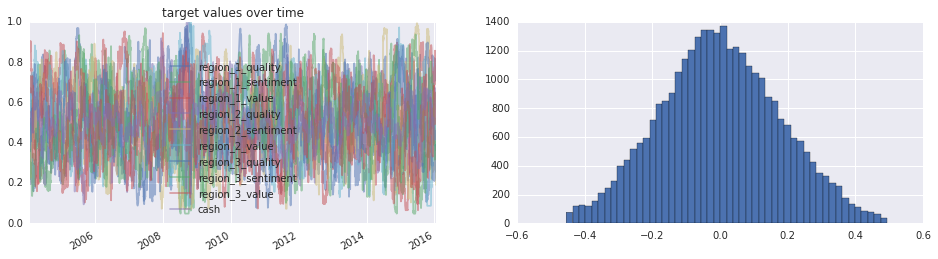

In [69]:
scaler = 25.
ys = opt_weights.applymap(lambda x: ut.sigmoid(x * scaler))

fig, axes = plt.subplots(ncols=2, figsize=[16,4])
ys.plot(ylim=[0,1], alpha=.5, title='target values over time', ax=axes[0])
(ys.stack()).sub(ys.stack().mean()).hist(bins=50, ax=axes[1])
ys.corr()

In [70]:
# Xs = (pd.read_hdf('data/scores.h5', 'scores')
#       .swapaxes('items', 'major_axis')
#       .swapaxes('minor_axis', 'major_axis'))

# set Xs to forward looking returns
cum_ret = ret.applymap(lambda x: x + 1.).cumprod()
Xs = (cum_ret.shift(-look_ahead_per).div(cum_ret) - 1.).dropna(how='all')
Xs_pre_noise = Xs.copy(deep=True)
Xs = add_noise_to_df(Xs, .0)
Xs = ts_score(Xs)
print('X-X_pre_noise corr:\t{0}'.format(pd.concat([Xs.stack(), Xs_pre_noise.stack()], axis=1).dropna().corr().iloc[0,1]))
print('X-y corr:\t\t{0}'.format(pd.concat([Xs.stack(), ys.stack()], axis=1).dropna().corr().iloc[0,1]))

X-X_pre_noise corr:	0.899215497737
X-y corr:		0.829070253579


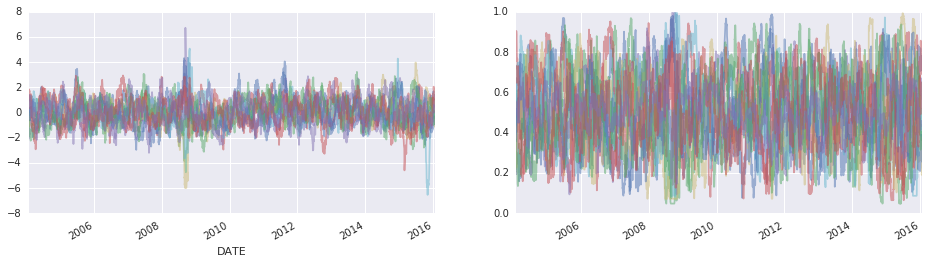

In [71]:
fig, axes = plt.subplots(ncols=2, figsize=[16,4])
Xs.plot(legend=False, alpha=.5, ax=axes[0])
ys.plot(legend=False, alpha=.5, ax=axes[1], ylim=[0,1])

In [72]:
print Xs.shape, ys.shape

Xs, ys = validate_and_format_Xs_ys(Xs, ys)
train, test = split_inputs_by_date(Xs, ys, datetime.date(2013,1,1), buffer_periods=look_ahead_per)
Xs_train, ys_train = train[0], train[1]
Xs_test, ys_test = test[0], test[1]

# Xs_train_f = flatten_panel(Xs_train)
# Xs_test_f = flatten_panel(Xs_test)

print Xs_train.shape, ys_train.shape

(3112, 10) (3112, 10)
(2291, 10) (2291, 10)


train model

In [73]:
from ml.model import *
# log_path = '/project/data/tensor_board'
# clear_path(log_path)
structure = [[],[100,100]]
preds, stats = train_nn_softmax([Xs_train.values, Xs_test.values], 
                                [ys_train.values, ys_test.values], 
                                structure, 100000, 1000, 1e-2, penalty_alpha=0., 
                                dropout_rate=0., verbosity=5000,
                                fc_final_layer_activation=tf.sigmoid)

step       0:	train loss: 0.72	test loss: 0.72		(0.07 sec)
step    5000:	train loss: 0.68	test loss: 0.69		(54.81 sec)
step   10000:	train loss: 0.68	test loss: 0.68		(113.94 sec)
step   15000:	train loss: 0.67	test loss: 0.68		(166.82 sec)
step   20000:	train loss: 0.66	test loss: 0.67		(213.85 sec)
step   25000:	train loss: 0.66	test loss: 0.66		(260.94 sec)
step   30000:	train loss: 0.65	test loss: 0.66		(307.92 sec)
step   35000:	train loss: 0.65	test loss: 0.66		(354.99 sec)
step   40000:	train loss: 0.65	test loss: 0.65		(407.54 sec)
step   45000:	train loss: 0.64	test loss: 0.65		(454.52 sec)
step   50000:	train loss: 0.64	test loss: 0.65		(501.92 sec)
step   55000:	train loss: 0.64	test loss: 0.64		(549.02 sec)
step   60000:	train loss: 0.63	test loss: 0.64		(595.91 sec)
step   65000:	train loss: 0.63	test loss: 0.64		(642.82 sec)
step   70000:	train loss: 0.64	test loss: 0.64		(689.95 sec)
step   75000:	train loss: 0.63	test loss: 0.64		(737.19 sec)
step   80000:	train loss: 0

region_3_sentiment    0.437800
region_2_sentiment    0.451768
region_2_quality      0.465299
region_3_value        0.467045
region_3_quality      0.484068
region_2_value        0.487124
cash                  0.489742
region_1_value        0.516805
region_1_quality      0.532519
region_1_sentiment    0.580969
dtype: float64

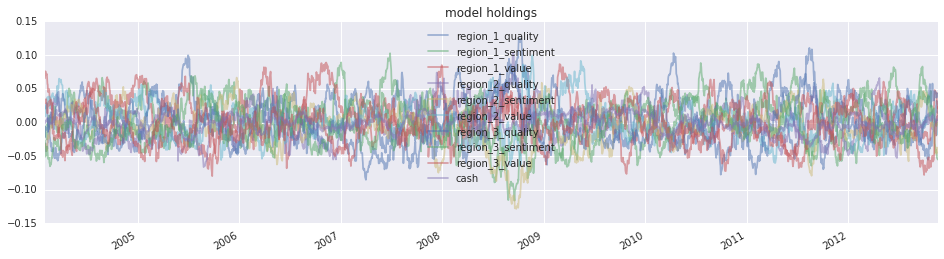

In [74]:
train_probs = pd.DataFrame(preds['train']['weights'], columns=ys_train.columns, index=ys_train.index)
train_probs = train_probs.applymap(lambda x: ut.from_sigmoid(x) / scaler)
train_probs.plot(figsize=[16,4], alpha=.5, title='model holdings', ylim=[-.15,.15])
ut.calc_ratio_above_zero(train_probs).sort_values()

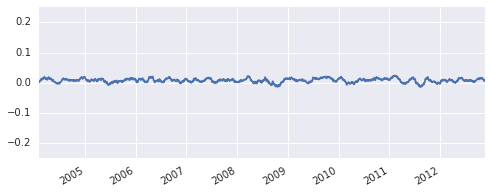

In [78]:
train_probs.sum(axis=1).plot(ylim=[-.25,.25], figsize=[8,3])

In [76]:
cols = list(ys.columns)
cols = dict(map(lambda x: (cols.index(x), x), cols))
train_labels = pd.Series(preds['train']['labels']).map(lambda x: cols[x])
print('predicted max columns:')
print train_labels.value_counts()
print
print('actual max columns:')
print ys_train.apply(lambda x: list(x).index(max(x)), axis=1).map(lambda x: cols[x]).value_counts()

predicted max columns:
region_1_sentiment    436
region_1_quality      351
region_1_value        350
region_3_quality      270
region_2_value        226
region_2_quality      194
region_3_sentiment    165
region_2_sentiment    149
region_3_value        148
cash                    2
dtype: int64

actual max columns:
region_1_sentiment    435
region_1_value        344
region_1_quality      317
region_3_quality      250
region_2_value        232
region_2_sentiment    204
region_2_quality      188
region_3_sentiment    168
region_3_value        151
cash                    2
dtype: int64


performance

train
equal_weights    3.867724
model_weights    4.121117
opt_weights      5.685639
tilt_weights     4.052508
dtype: float64

test
equal_weights    3.332415
model_weights    3.087910
opt_weights      6.728101
tilt_weights     3.343299
dtype: float64



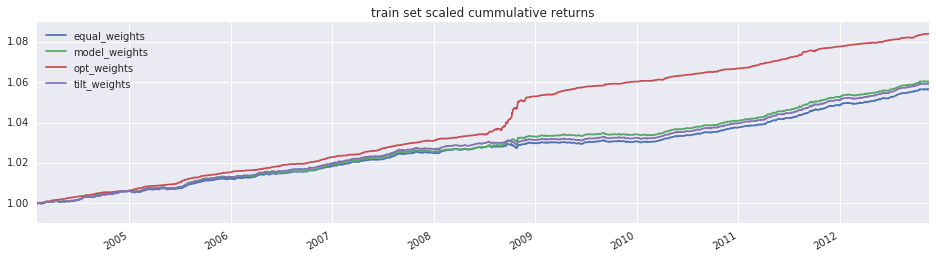

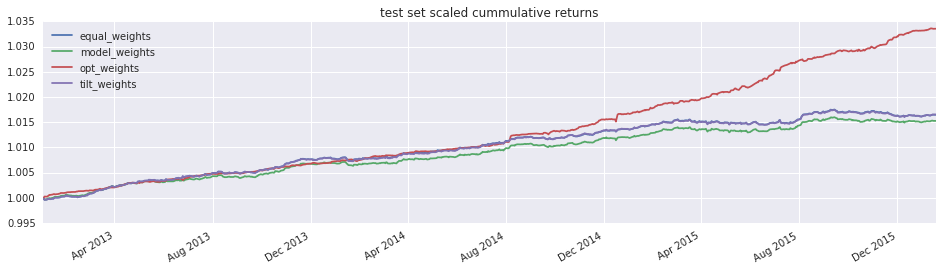

In [77]:
def plot_perf(group):
    if group == 'train':
        target = ys_train
    else:
        target = ys_test
    
    equal_weights = pd.Series({k: 1./target.shape[1] for k in target.columns})
    probs = pd.DataFrame(preds[group]['weights'], columns=target.columns, index=target.index)
    perf = pd.DataFrame({'equal_weights': ret.mul(equal_weights).sum(axis=1),
                         'tilt_weights': ret.mul(tilt_weights).sum(axis=1),
                         'opt_weights': ret.mul(opt_weights).sum(axis=1),
                         'model_weights': ret.mul(probs).sum(axis=1)
                        })
    perf = perf.loc[probs.index]
    risk = perf.std(axis=0)
    perf_scaled = perf.mul(1e-4 / risk)
    title = group + ' set scaled cummulative returns'
    perf_scaled.applymap(lambda x: x + 1).cumprod().plot(figsize=[16,4], title=title)
    
    print ut.get_ir(perf)

for i in ('train', 'test'):
    print(i)
    plot_perf(i)
    print